## Load Libraries

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
# Read the datasets
true_df = pd.read_csv("News _dataset/True.csv")
fake_df = pd.read_csv("News _dataset/Fake.csv")

# Add labels 
true_df['label'] = 1
fake_df['label'] = 0

display(true_df)
display(fake_df)


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


## Cleaning Text

In [13]:
import re

def clean_intro(text):
    # Pattern 1: Remove "(Reuters) -", "XYZ (Reuters) -", etc.
    text = re.sub(r"^.*\(Reuters\)\s*-\s*", "", text)

    # Pattern 2: Remove boilerplate Twitter intros (before the real statement)
    text = re.sub(r"^The following statements.*?@realDonaldTrump\s*:\s*-\s*", "", text, flags=re.IGNORECASE | re.DOTALL)

    return text.strip()

### Cleaning true_df 

In [14]:
true_df["text"] = true_df["text"].apply(clean_intro)
display(true_df)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,NATO allies on Tuesday welcomed President Dona...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LexisNexis, a provider of legal, regulatory an...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,In the shadow of disused Soviet-era factories ...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,Vatican Secretary of State Cardinal Pietro Par...,worldnews,"August 22, 2017",1


### Cleaning fake_df

In [15]:
import pandas as pd
import re

def clean_fake_text(text):
    # Lowercase text to ensure fake news removal is case-insensitive
    text = re.sub(r'fake news', '', text, flags=re.IGNORECASE)

    # Remove specific intros
    text = re.sub(r"21st Century Wire says\s*", "", text)
    text = re.sub(r"Jay Dyer 21st Century WireIn\s*", "", text)
    # Remove '21WIRE' in any form (e.g., '21wire', '21 WIRE', '21 Wire')
    text = re.sub(r"21\s*wire", "", text, flags=re.IGNORECASE)

    # Remove promotional endings
    text = re.sub(r"SUPPORT OUR WORK BY SUBSCRIBING.*?21WIRE.TV", "", text, flags=re.IGNORECASE | re.DOTALL)

    # Truncate to first 500 words
    words = text.split()
    if len(words) > 500:
        text = " ".join(words[:500])

    return text.strip()

# clean
fake_df["text"] = fake_df["text"].apply(clean_fake_text)

display(fake_df)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,"As reported earlier this week, the unlikely mi...",Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,It s a familiar theme. Whenever there is a dis...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember w...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,Al Jazeera America will go down in history as ...,Middle-east,"January 14, 2016",0


## Save to CSV file

In [16]:
fake_df.to_csv("News _dataset/Fake_cleaned.csv", index=False)
true_df.to_csv("News _dataset/true_cleaned.csv", index=False)

In [17]:
# Combine and shuffle datasets
df = pd.concat([true_df, fake_df]).sample(frac=1).reset_index(drop=True)

# Use only title+text for classification
df['content'] = df['title'] + ' ' + df['text']

display(df.head())

,title,text,subject,date,label,content
0,NSA director Rogers is top candidate for DNI u...,U.S. National Security Agency Director Admiral...,politicsNews,"November 18, 2016",1,NSA director Rogers is top candidate for DNI u...
1,Patton Oswalt’s Screed Against Donald Trump I...,"Patton Oswalt is a comedian, but he s also ver...",News,"November 27, 2016",0,Patton Oswalt’s Screed Against Donald Trump I...
2,GAME CHANGER: HOW TRUMP IS BRINGING BACK The “...,One of the most interesting and insightful pie...,politics,"May 10, 2016",0,GAME CHANGER: HOW TRUMP IS BRINGING BACK The “...
3,South Africa's new ANC leader Ramaphosa aims t...,"Cyril Ramaphosa, the new leader of South Afric...",worldnews,"December 20, 2017",1,South Africa's new ANC leader Ramaphosa aims t...
4,Black caucus members urge U.S. Representative ...,Some of Democratic U.S. Representative John Co...,politicsNews,"November 29, 2017",1,Black caucus members urge U.S. Representative ...


In [18]:
# Convert uppercase to lowercase
df["content"] = df["content"].str.lower()

display(df.head())

,title,text,subject,date,label,content
0,NSA director Rogers is top candidate for DNI u...,U.S. National Security Agency Director Admiral...,politicsNews,"November 18, 2016",1,nsa director rogers is top candidate for dni u...
1,Patton Oswalt’s Screed Against Donald Trump I...,"Patton Oswalt is a comedian, but he s also ver...",News,"November 27, 2016",0,patton oswalt’s screed against donald trump i...
2,GAME CHANGER: HOW TRUMP IS BRINGING BACK The “...,One of the most interesting and insightful pie...,politics,"May 10, 2016",0,game changer: how trump is bringing back the “...
3,South Africa's new ANC leader Ramaphosa aims t...,"Cyril Ramaphosa, the new leader of South Afric...",worldnews,"December 20, 2017",1,south africa's new anc leader ramaphosa aims t...
4,Black caucus members urge U.S. Representative ...,Some of Democratic U.S. Representative John Co...,politicsNews,"November 29, 2017",1,black caucus members urge u.s. representative ...


In [19]:
# Save to .csv file
df[["content", "label"]].to_csv("cleaned_news.csv", index=False)

## EDA

title      0
text       0
subject    0
date       0
label      0
content    0
dtype: int64
label
0    23481
1    21417
Name: count, dtype: int64


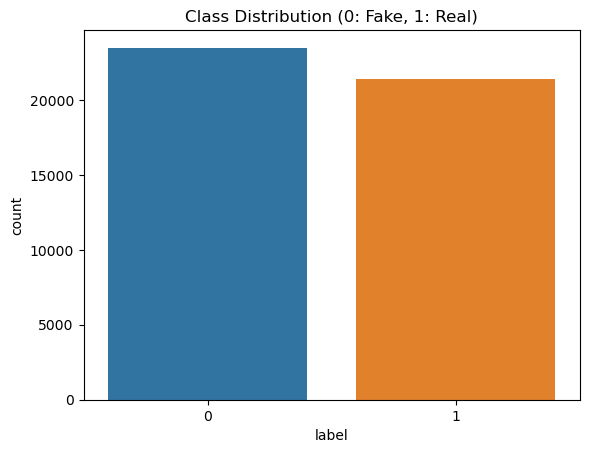

In [20]:
# Check for nulls
print(df.isnull().sum())

# Check class imbalance
print(df['label'].value_counts())

# Visualize plot
sns.countplot(x="label", data=df)
plt.title("Class Distribution (0: Fake, 1: Real)")
plt.show()

No null values.

Classes are not too imbalanced!